In [ ]:
import numpy as np

# Broadcasted shape
def broadcasted_shape(shape_X, shape_Y):

    max_len = max(len(shape_X), len(shape_Y))
    min_len = min(len(shape_X), len(shape_Y))
    swapped = False

    if len(shape_X) < max_len:
        swapped = True
        L, S = shape_Y, shape_X # L = long, S = short
    else:
        L, S = shape_X, shape_Y

    L_rev = L[::-1]
    S_rev = S[::-1]

    result_shape = []
    axes_L_expanded = []
    axes_S_expanded = []

    for i in range(min_len):
        dim_L = L_rev[i]
        dim_S = S_rev[i]
        if dim_L == 1 and dim_S != 1:
            axes_L_expanded.append(max_len  -1- i)
        elif dim_L != 1 and dim_S == 1:
            axes_S_expanded.append(max_len  -1- i)
        if dim_L == 1 or dim_S == 1 or dim_L == dim_S:
            result_shape.append(max(dim_L,dim_S))
        else:
            raise ValueError(f"Shapes {shape_X} and {shape_Y} not broadcastable")


    result_shape += L_rev[(min_len):]

    result_shape = tuple(result_shape[::-1])
    axes_L_expanded = tuple(axes_L_expanded[::-1])
    axes_S_expanded = tuple(axes_S_expanded[::-1])

    if swapped:
        return result_shape, axes_S_expanded, max_len - min_len,  axes_L_expanded, 0
    else:
        return result_shape,  axes_L_expanded, 0, axes_S_expanded, max_len - min_len

def unbroadcast(arr, ax, pad):
    return np.sum(np.sum(arr, axis = ax, keepdims = True), axis = tuple(range(pad)))



class ag: # AutoGrad

    #################
    # ENTRYWISE OPS #
    #################
    def log(input):
        output = ag.Tensor(np.log(input.value), inputs=[input], op="log")
        def _backward():
            input.grad += output.grad / input.value
            return None
        output._backward = _backward
        return output

    def exp(input):

        output = ag.Tensor(np.exp(input.value), inputs=[input], op="exp")

        def _backward():
            input.grad += output.grad * output.value
            return None

        output._backward = _backward
        return output

    def relu(input):
        output = ag.Tensor(np.maximum(0, input.value), inputs=[input], op="relu")

        def _backward():
            input.grad += (input.value > 0)*output.grad
            return None

        output._backward = _backward
        return output



    #################
    # REDUCTIVE OPS #
    #################
    def sum(input,axis = None, keepdims = False):
        output = ag.Tensor(np.sum(input.value, axis = axis, keepdims = keepdims), inputs = [input], op='sum')
        def _backward():
            if axis == None or keepdims:
                input.grad += output.grad
            else:
                input.grad += np.expand_dims(output.grad, axis = axis)
            return None
        output._backward = _backward
        return output

    def matmul(input1, input2):
        return input1@input2
    ###############
    # SHAPING OPS #
    ###############

    def expand_dims(input, axis):
        output = ag.Tensor(np.expand_dims(input.value,axis=axis), inputs = [input])
        def _backward():
            input.grad += np.squeeze(output.grad, axis = axis)
            return None
        output._backward = _backward
        return output

    def reshape(input, newshape):
        output = ag.Tensor(np.reshape(input.value, newshape), inputs=[input], op="reshape")
        def _backward():
            input.grad += np.reshape(output.grad, input.shape)
            # YOUR CODE HERE
            return None
        output._backward = _backward
        return output


    class Tensor: # Tensor with grads
        def __init__(self,
                     value,
                     op="",
                     _backward= lambda : None,
                     inputs=[],
                     label=""):

            if type(value) in [float ,int]:
                value = np.array(value)
            self.value = 1.0*value
            self.grad = np.zeros_like(self.value)

            self.shape = value.shape

            self._backward = _backward
            self.inputs = inputs

            self.op = op
            self.label = label

        def topological_sort(self):
            topo_order = []
            visited = set()

            def dfs(node):
                if node not in visited:
                    visited.add(node)
                    for input in node.inputs:
                        dfs(input)
                    topo_order.append(node)

            dfs(self)
            return topo_order

        def backward(self):
            self.grad = np.array(1.0)

            topo_order = self.topological_sort()

            for node in reversed(topo_order):
                node._backward()



        def __add__(self, other):
            if type(other) in [float, int]:
                other = ag.Tensor(1.0*other)
            result_shape, ax1, pad1, ax2, pad2 = broadcasted_shape(self.shape, other.shape)

            output = ag.Tensor(self.value + other.value,
                               inputs=[self, other], op="add")
            def _backward():
                self.grad += unbroadcast(output.grad, ax1, pad1)
                other.grad += unbroadcast(output.grad, ax2, pad2)

            output._backward = _backward
            return output

        def __sub__(self,other):
            return self + other*(-1)

        def __neg__(self):
            output = ag.Tensor(-self.value, inputs=[self], op="neg")
            def _backward():
                self.grad -= output.grad
                return None
            output._backward = _backward
            return output

        def __mul__(self, other):
            if type(other) in [float, int]:
                other = ag.Tensor(1.0*other)
            result_shape, ax1, pad1, ax2, pad2 = broadcasted_shape(self.shape, other.shape)

            output = ag.Tensor(self.value * other.value,
                               inputs=[self, other], op="mul")
            def _backward():
                self.grad += unbroadcast(output.grad*other.value, ax1, pad1)
                other.grad += unbroadcast(output.grad*self.value, ax2, pad2)

            output._backward = _backward
            return output

        def __truediv__(self,other):
            return self*(other**(-1))


        def __pow__(self, exponent): # exponent is just a python float
            output = ag.Tensor(self.value ** exponent,
                               inputs=[self],
                               op=f"pow({exponent})")

            def _backward():

                self.grad += (exponent * self.value**(exponent-1)) * output.grad
                return None

            output._backward = _backward
            return output


        def __getitem__(self, idx):
            output = ag.Tensor(np.array(self.value[idx]),
                               inputs = [self],
                               op=f"[...]")
            def _backward():
                self.grad[idx] += output.grad # idx must not have repeats!
                return None
            output._backward = _backward
            return output


        def __matmul__(self,other):
            output = ag.Tensor(np.matmul(self.value,other.value),
                               inputs = [self,other],
                               op="matmul")

            # self.shape = (a,b,c, m,n)
            # other.shape = (a,b,c, n,p)
            # output.grad.shape == output.value.shape = (a,b,c, m,p)


            def _backward():
                if len(other.value.shape) == 1:
                    if len(self.value.shape) == 1:
                        raise Exception("To take the dot-product of two vectors, use ag.sum(x*y) instead.")
                    else:
                        self.grad += np.matmul(output.grad[:,None], other.value[None,:])
                else:
                    self.grad += np.matmul(output.grad, np.moveaxis(other.value,-1,-2))
                axis = list(range(len(self.value.shape)-1))
                other.grad += np.tensordot(self.value, output.grad, axes = [axis,axis])
                return None
            output._backward = _backward
            return output

        def __repr__(self) -> str:
            return "Value:\n"+self.value.__repr__() + "\nGrad:\n" + self.grad.__repr__()
        # def __repr__(self) -> str:
        #     return "Value:\n"+self.value.__repr__() + "\nGrad:\n" + self.grad.__repr__()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

def build_computation_graph(final_scalar):
    graph = nx.DiGraph()

    # DFS
    topo_order = final_scalar.topological_sort()

    # Count how many leaves
    # By convention, we hand-label our inputs
    # constants are labeled automatically
    labeled_nodes = [node for node in topo_order if node.label != "" and 'const' not in node.label]
    index = len(labeled_nodes) + 1

    for node in topo_order:
        if not node.label:  # If a node has no label, assign one
            node.label = f"z{index}"
            index += 1

        graph.add_node(node)
        if len(node.inputs) > 1:
            for idx, input_node in enumerate(node.inputs):
                graph.add_edge(input_node, node)
        elif len(node.inputs) == 1:
            graph.add_edge(node.inputs[0], node)

    return graph

def plot_computation_graph(graph, rad=0.2,node_size=2000):
    node_labels = {node: node.label + "\n" + node.op if node.op != "" else node.label for node in graph.nodes}

    # Assign layers to nodes for multipartite layout
    for layer, nodes in enumerate(nx.topological_generations(graph)):
        for node in nodes:
            graph.nodes[node]["layer"] = layer

    pos = nx.multipartite_layout(graph, subset_key="layer")

    node_colors = []
    node_edge_colors = []

    for node in graph.nodes:
        if "leaf" in node.label:
            node_colors.append('none')  # Input nodes: no fill
            node_edge_colors.append('black')
        elif "const" in node.label:
            node_colors.append('none')
            node_edge_colors.append('lightgray')
        else:
            node_colors.append('lightblue')
            node_edge_colors.append('none')

    curved_edges = []
    straight_edges = []

    for node in graph.nodes:
        incoming_edges = list(graph.in_edges(node))
        if len(incoming_edges) > 1:
            curved_edges.extend(incoming_edges)
        else:
            straight_edges.extend(incoming_edges)

    # Draw straight edges
    nx.draw(graph, pos, with_labels=False, edgelist=straight_edges,
            node_color=node_colors, edgecolors=node_edge_colors, node_size=node_size,
            font_size=10, font_weight='bold', arrows=True)

    # Draw curved edges with a specified curvature
    nx.draw(graph, pos, with_labels=False, edgelist=curved_edges,
            connectionstyle=f'arc3, rad={rad}', node_color=node_colors,
            edgecolors=node_edge_colors, node_size=node_size, font_size=10,
            font_weight='bold', arrows=True)

    nx.draw_networkx_labels(graph, pos=pos, labels=node_labels)


## A simple example

x.grad [ 6.  7.  8.  9. 10. 11.]
y.grad [0. 1. 2. 3. 4. 5.]


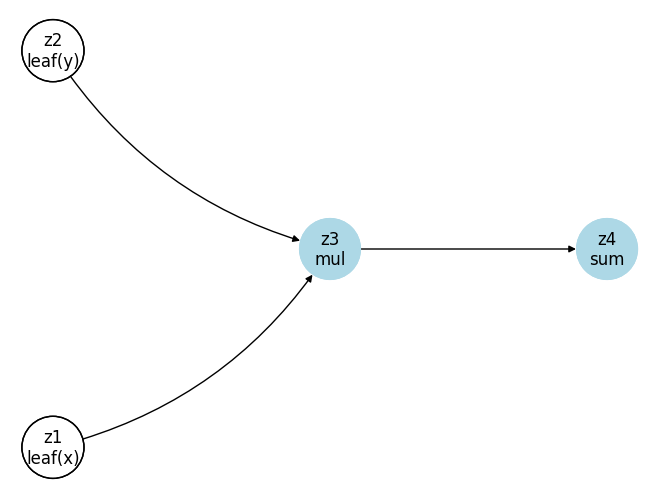

In [ ]:
x = ag.Tensor(np.arange(6), label='z1\nleaf(x)')
y = ag.Tensor(np.arange(6,6+6), label='z2\nleaf(y)')
# output = ag.matmul(x,y)

output = ag.sum(x*y)
output.backward()
computation_graph = build_computation_graph(output)
plot_computation_graph(computation_graph,0.2)
print("x.grad", x.grad)
print("y.grad", y.grad)

# Exercise 2.1: Fix the `_backward` for `ag.reshape`

`x.grad` and `y.grad` should match the output from the previous cell

x.grad [0. 0. 0. 0. 0. 0.]
y.grad [0. 0. 0. 0. 0. 0.]


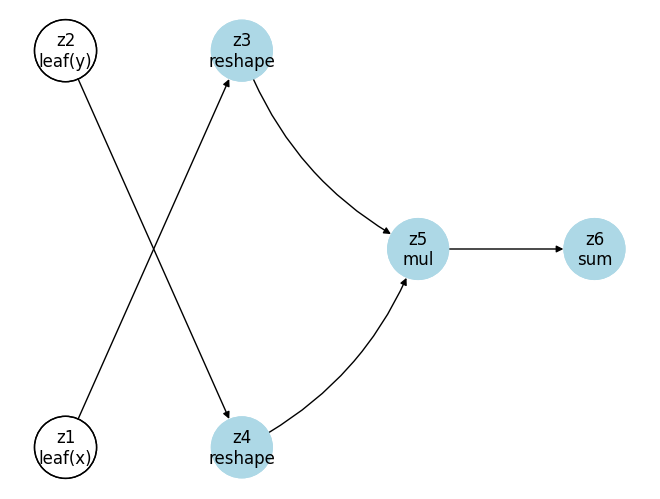

In [ ]:
x = ag.Tensor(np.arange(6), label='z1\nleaf(x)')
y = ag.Tensor(np.arange(6,6+6), label='z2\nleaf(y)')

output = ag.sum(ag.reshape(x,(3,2)) * ag.reshape(y,(3,2)))
output.backward()
computation_graph = build_computation_graph(output)
plot_computation_graph(computation_graph,0.2)

print("x.grad", x.grad)
print("y.grad", y.grad)

# Loss derivative for softmax

## For a single $z$

In [ ]:
np.random.seed(42)

z = ag.Tensor(np.random.randn(3),label="z1\nleaf(z)")
expz = ag.exp(z)
p = expz/ ag.sum(expz)
nll = -ag.log(p[0]) # negative log-likelihood
nll.backward()
print("z.grad", z.grad)
print("manual", p.value - np.eye(3)[0,:])

z.grad [-0.62865502  0.19679312  0.4318619 ]
manual [-0.62865502  0.19679312  0.4318619 ]


## For multiple $z$'s:

### Exercise 2.2: what's wrong with this code?

The manually computed gradients and the autogradients do not agree

In [ ]:
np.random.seed(42)
N = 4
K = 3
z = ag.Tensor(np.random.randn(N,K),label="z1\nleaf(z)")
y = np.array([0,0,1,2])
expz = ag.exp(z)
p = expz/ ag.sum(expz, axis=-1, keepdims=True)
nll = ag.sum(-ag.log(p[np.arange(N),y]))

nll.backward()
print("z.grad", z.grad)
print("manual", p.value - np.eye(K)[y,:])

z.grad [[ 0.11403493 -0.40962064  0.29558571]
 [ 1.23037856 -0.61519244 -0.61518612]
 [ 0.90721793 -0.15306598 -0.75415195]
 [ 0.73357364 -0.36605481 -0.36751883]]
manual [[-0.62865502  0.19679312  0.4318619 ]
 [-0.25654048  0.12826919  0.12827129]
 [ 0.63573931 -0.71768866  0.08194935]
 [ 0.57785788  0.21131506 -0.78917294]]


# A more pytorch-like framework

In [ ]:

class nn:
    # A fake python class so that we can use nn as an "namespace"
    # This way we can avoid having an actual python module
    # which would create more files for you to have to download
    # and for me to upload.

    # But the sacrifice is that the class inheritance is a bit wonky
    # Maybe someone more well-versed in python class inheritance can help me out
    # Email me if you'd like to contribute to making this class better next time

    class Module:
        def __init__(self):
            self._parameters = {}
            self._modules = {}

        def forward(self, *inputs):
            raise NotImplementedError

        def __call__(self, *inputs):
            return self.forward(*inputs)

        def parameters(self):
            params = list(self._parameters.values())
            for module in self._modules.values():
                params.extend(module.parameters())
            return params

        def __setattr__(self, name, value):
            object.__setattr__(self, name, value)
            if isinstance(value, nn.Module):
                self._modules[name] = value
            elif isinstance(value, ag.Tensor):
                self._parameters[name] = value


    class Linear(Module):
        def __init__(self, in_features, out_features):
            nn.Module.__init__(self)
            self.weight = ag.Tensor(np.random.randn(in_features, out_features))
            self.bias = ag.Tensor(np.random.randn(out_features))

            # these do not trigger __setattr__
            self._parameters['weight'] = self.weight
            self._parameters['bias'] = self.bias

        def forward(self, x):
            return ag.matmul(x, self.weight) + self.bias

    class MSELoss:
        def __call__(self, input, target):
            N = target.value.shape[0]
            return ag.sum((target - input)**2) / N

    class BinaryCrossEntropyLoss:
        def __call__(self, input, target):
            N = target.value.shape[0]
            return ag.sum( ag.log( ag.exp(-target*input)+1.0 )) / N

class optim:
    class SGD:
        def __init__(self, parameters, lr=0.01):
            self.parameters = parameters
            self.lr = lr

        def step(self):
            for p in self.parameters:
                p.value -= self.lr * p.grad

        def zero_grad(self):
            for p in self.parameters:
                p.grad = np.zeros_like(p.value)



# `TwoLayerPerceptron`

From `lec03-in-class-ex2-relu-net`.

In [ ]:
class TwoLayerPerceptron(nn.Module):
    def __init__(self, n_hidden):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(1, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        # note: this does not trigger __setattr__ because x is not an attribute
        x = self.fc1(x)
        x = ag.relu(x)
        x = self.fc2(x)

        return x

        # if you want nn.Module to keep track of model's internal quantities
        # do, for instance,
        # self.pre_activation = self.fc1(x)
        # self.activation = ag.relu(self.pre_activation)
        # output = self.fc2(self.activation)
        # return output


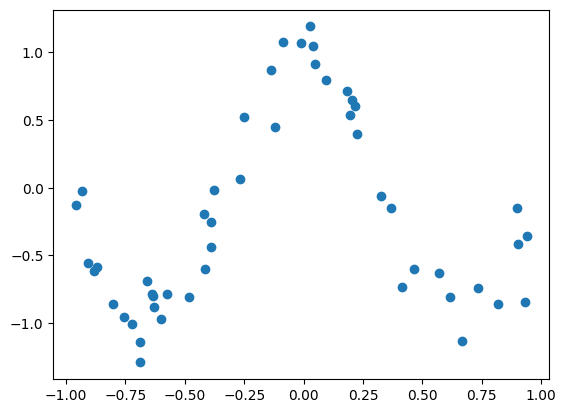

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 50

np.random.seed(42)
xnp = 2.0*(np.random.rand(N)-0.5)

eps = (1/5)*np.random.randn(N)
ynp = np.cos((3/2)*np.pi*xnp) + eps
plt.scatter(xnp, ynp)

### Wrapping the data in ag.Tensor

In [ ]:
x = ag.Tensor(np.expand_dims(xnp,axis=1), label="z1\nleaf(x)")
y = ag.Tensor(np.expand_dims(ynp,axis=1), label="z2\nleaf(y)")

### Construct the model

In [ ]:
n_hidden = 20
model  = TwoLayerPerceptron(n_hidden)
np.random.seed(42)

# use the previous weights (with same rng seed)
w1np = np.random.randn(n_hidden)
b1np = np.random.randn(n_hidden)
w2np = np.random.randn(n_hidden)
b2np = np.random.randn(1)
w1 = ag.Tensor(np.expand_dims(w1np, axis = 0),label='w1\nleaf')
b1 = ag.Tensor(b1np, label='b1\nleaf')
b2 = ag.Tensor(b2np, label='b1\nleaf')
w2 = ag.Tensor(np.expand_dims(w2np,axis = 1), label='w2\nleaf')

# manually override the params
model.fc1.weight = w1
model.fc1.bias = b1
model.fc2.weight = w2
model.fc2.bias = b2

# make optim and
optimizer = optim.SGD(model.parameters(), lr=0.1)

criterion = nn.MSELoss()

## Train!

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

## Visualize!

Your model won't show up until the error is fixed.

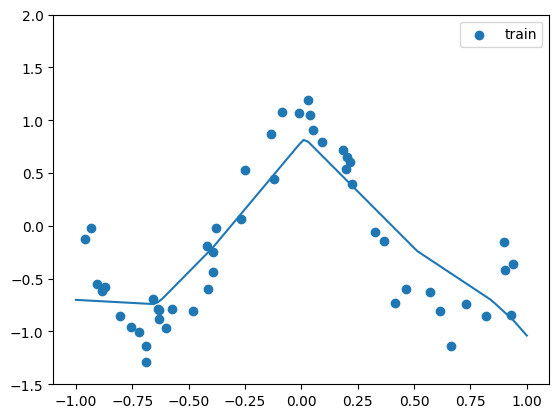

In [ ]:
plt.scatter(xnp,ynp, label='train')
plt.ylim([-1.5,2.0])

x_grid = np.linspace(-1,1,100)

y_grid = model(ag.Tensor(x_grid[:,None])).value

plt.plot(x_grid,y_grid)
plt.legend()

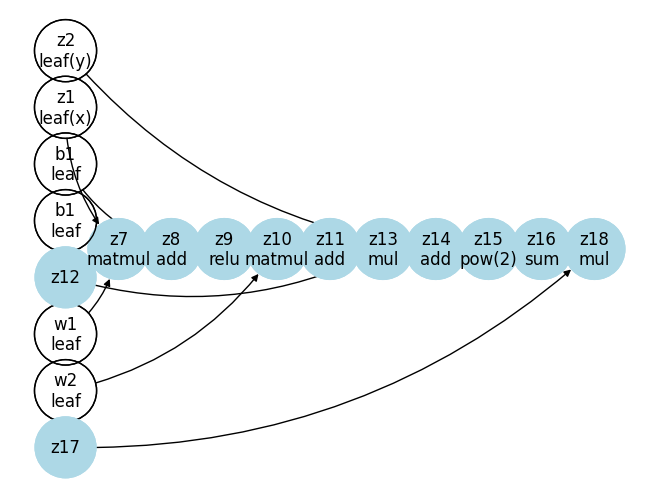

In [ ]:
outputs = model(x)
loss = criterion(outputs, y)
loss.backward()
computation_graph = build_computation_graph(loss)
plot_computation_graph(computation_graph,0.2)


# MultiLayerPerceptron (MLP)

In [ ]:
class FourLayerPerceptron(nn.Module):
    def __init__(self, n_hiddens):
        # n_hiddens is a list of integers > 2
        # len(n_hiddens) == 3

        nn.Module.__init__(self)
        self.n_hiddens = n_hiddens
        self.fc1 = nn.Linear(1, n_hiddens[0])
        self.fc2 = nn.Linear(n_hiddens[0], n_hiddens[1])
        self.fc3 = nn.Linear(n_hiddens[1], n_hiddens[2])
        self.fc4 = nn.Linear(n_hiddens[2], 1)

    def forward(self, x):
        # note: this does not trigger __setattr__ because x is not an attribute
        x = self.fc1(x)
        x = ag.relu(x)
        x = self.fc2(x)
        x = ag.relu(x)
        x = self.fc3(x)
        x = ag.relu(x)
        x = self.fc4(x)
        return x

        # if you want nn.Module to keep track of model's internal quantities
        # do, for instance,
        # self.pre_activation = self.fc1(x)
        # self.activation = ag.relu(self.pre_activation)
        # output = self.fc2(self.activation)
        # return output


In [ ]:

# model(x)

In [ ]:
n_hiddens = [4,8,16]
model = FourLayerPerceptron(n_hiddens)

optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.MSELoss()

num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

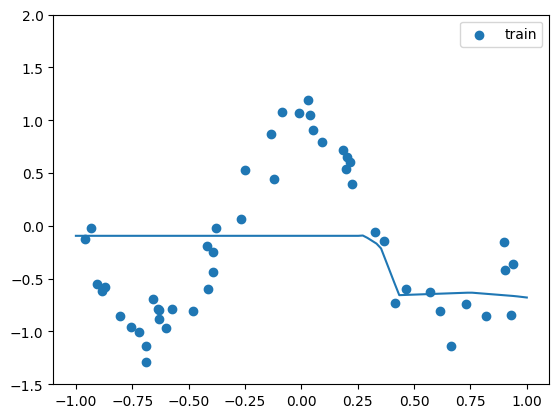

In [ ]:
plt.scatter(xnp,ynp, label='train')
plt.ylim([-1.5,2.0])

x_grid = np.linspace(-1,1,100)

y_grid = model(ag.Tensor(x_grid[:,None])).value

plt.plot(x_grid,y_grid)
plt.legend()

# Make moons from `lec04-in-class-ex2-binary-NN`

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
n = 200
Xnp, ynp = make_moons(n_samples=n, noise=0.1, random_state=42)
ynp = 2*ynp-1
Xnp = Xnp - np.mean(Xnp,axis=0)


d = 2   # Input dimension
m = 10  # Number of hidden units



In [ ]:
#                   red                  or    blue
mycolormap = list(["#D81B60" if ynp[i] > 0 else "#1E88E5" for i in range(len(ynp)) ])
def plot_data_scatter(X,i = None, ax=None):
    if ax is None:
        ax = plt.gca()
    if i is None:
        plt.scatter(X[:, 0], X[:, 1], c=mycolormap, s=50)
    else:

        plt.scatter(X[i, 0], X[i, 1], c='k', s=300)
        plt.scatter(X[i, 0], X[i, 1], c=mycolormap[i], s=250)

def plot_decision_boundary(X, model,ax=None):
    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    grid_points = np.c_[xx.ravel(), yy.ravel()]

    z = model(ag.Tensor(grid_points)).value

    predictions = np.sign(z).reshape(xx.shape)
    # print(predictions)

    ax.contourf(xx, yy, predictions, cmap='coolwarm', alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=mycolormap, edgecolor='k')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)




In [ ]:
class FourLayerPerceptron2Dims(nn.Module):
    def __init__(self, n_hiddens):
        # n_hiddens is a list of integers > 2
        # len(n_hiddens) == 3

        nn.Module.__init__(self)
        self.n_hiddens = n_hiddens
        self.fc1 = nn.Linear(2, n_hiddens[0])
        self.fc2 = nn.Linear(n_hiddens[0], n_hiddens[1])
        self.fc3 = nn.Linear(n_hiddens[1], n_hiddens[2])
        self.fc4 = nn.Linear(n_hiddens[2], 1)

    def forward(self, x):
        # note: this does not trigger __setattr__ because x is not an attribute
        x = self.fc1(x)
        x = ag.relu(x)
        x = self.fc2(x)
        x = ag.relu(x)
        x = self.fc3(x)
        x = ag.relu(x)
        x = self.fc4(x)
        return x

        # if you want nn.Module to keep track of model's internal quantities
        # do, for instance,
        # self.pre_activation = self.fc1(x)
        # self.activation = ag.relu(self.pre_activation)
        # output = self.fc2(self.activation)
        # return output


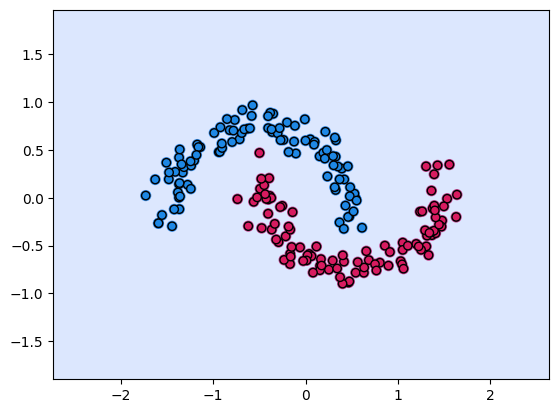

In [ ]:
model = FourLayerPerceptron2Dims(n_hiddens)
plot_data_scatter(Xnp)
plot_decision_boundary(Xnp,model)

In [ ]:
x = ag.Tensor(Xnp)
y = ag.Tensor(1.0*ynp[:,np.newaxis])
optimizer = optim.SGD(model.parameters(), lr=0.1)

criterion = nn.BinaryCrossEntropyLoss()

In [ ]:
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()



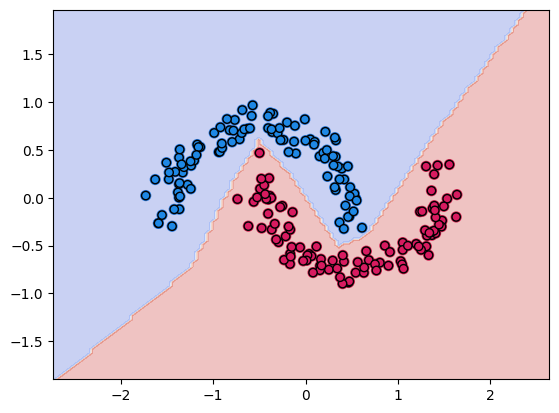

In [ ]:
plot_data_scatter(Xnp)
plot_decision_boundary(Xnp,model)